# Libraries

In [1]:
import os
import sys

current_dir = os.getcwd()
resources_folder = os.path.join(current_dir, '..', 'resources')
sys.path.append(resources_folder)

os.listdir()

['1_validate_initial_files.ipynb',
 '2_retrain_otr_adjudication.ipynb',
 '3_otr_adjudication_pipeline.ipynb',
 '4_otr_existing_exposure_evaluation.ipynb',
 'models.pkl',
 'normalization.pkl']

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from dotenv import load_dotenv
from typing import List, Dict, Optional, Tuple
from statsmodels.discrete.discrete_model import Logit, BinaryResultsWrapper
from sklearn.metrics import roc_auc_score, average_precision_score
import pickle


import snowflake_connector as sc
import model_training as mt
import existing_exposure as ee
import config

# Data reading and processing

**OTR_ADJ_RISK_PREPROCESSED_SAMPLE_MODEL_MONITORING in OTR_ADJ_FLOW**

In [3]:
sf_conn = sc.snowflake_conn(user = "W515059")

c:\Users\W515059\AppData\Local\Programs\Python\Python38\lib\site-packages\snowflake\connector\config_manager.py:344: UserWarning: Bad owner or permissions on C:\Users\W515059\.snowflake\connections.toml
  warn(f"Bad owner or permissions on {str(filep)}{chmod_message}")


Initiating login request with your identity provider. A browser window should have opened for you to complete the login. If you can't see it, check existing browser windows, or your OS settings. Press CTRL+C to abort and try again...
Going to open: https://myapps.wexinc.com/app/snowflake/exkaea789nRrm6HV7357/sso/saml?SAMLRequest=pZNbc9owEIX%2Fikd9tiXMXYPJOKGZMEMTBpy0zZuwF6JiS0YrY%2Bivr8ylkz4kL32T5bP6zu6RRjeHIvf2YFBqFZFWwIgHKtWZVJuIPCf3%2FoB4aIXKRK4VROQISG7GIxRFXvK4sm9qAbsK0HruIIW8%2BRGRyiiuBUrkShSA3KZ8GX%2Bb8TBgXCCCsQ5HLiUZSsd6s7bklNZ1HdTtQJsNDRljlA2pUzWSL%2BQdovycURptdarza8nB9fQBokVZp0E4hSPML4W3Up1H8BlldRYhf0iSuT9%2FWibEi6%2Fd3WmFVQFmCWYvU3hezM4G0DlY7QTrDzosqNCv3ez8MCiN3AsLuVTbAJWu17nYQqqLsrIOEbgVXUNGc72RbnDTSUTKrcy%2BzkL4uf7BCsGW5epXr18fbhffQcVJr9t%2F2tjX9c506yx%2B%2FL1NifdyjTlsYp4iVjBVTbjWbbGw67OWH4ZJyHh3wNkwaPc6r8SbOINSCXuqvHZQHEVZYlDDQar05M5907%2FGKRy2AkR%2FMFQLU%2FQeXvrtbp8iatqER873h58cmPF%2FTWVE3x91uZePLqrpZK5zmR69e20KYT9OshW0Tjsy89cnKYdCyDzOMgOILtE81%2FWdAecjItZUQOj4TP33AYz%2FA

In [4]:
query = ''' 
        SELECT *
        FROM "SRC_RISK_FRAUD_SUB"."RISK_FRAUD"."OTR_ADJ_RISK_PREPROCESSED_SAMPLE_MODEL_MONITORING";
    '''

cur = sf_conn.cursor()
cur.execute(query)
df = pd.DataFrame.from_records(iter(cur), columns=[x[0] for x in cur.description])

print(df['decision_date'].min())
print(df['decision_date'].max())
df.head()

2019-01-02
2025-01-15


,application_number,ar_id,booked,decision_date,number_of_trucks_c,program_group,product_type_c,fraud_flag_c,existing_exposure_check_c,credit_line_requested_c,...,lexis_nexis_reason_code_4_c,adverse_action_code_c,offer_c,detailed_funding_type_2024,pg_required_c,b2bcnt2y_ln,sbfecardcount_ln,sbfeaccountcount_ln,sbfehitindex_ln,years_in_business_num_c
0,329681,3770002006978,True,2020-04-20,3.0,RTS Fleet One,OTR,False,Passed,0.0,...,None,A2,a3L700000004RGEEA2,UNKNOWN,False,NaN,NaN,NaN,NaN,19.0
1,551266,-1,False,2022-10-21,2.0,other,OTR,False,Passed,6400.0,...,None,F1,a3L0g000000HNphEAG,UNKNOWN,False,1.0,-99.0,-99.0,1.0,3.0
2,749868,-1,False,2024-11-01,NaN,other,None,False,Passed,NaN,...,None,I1,a3L0g00000193vPEAQ,UNKNOWN,True,NaN,NaN,NaN,NaN,1975.0
3,588464,-1,False,2023-03-15,1.0,Edge,OTR - LLC,False,Failed,3200.0,...,None,F7,a3L0g000000HJ7gEAG,UNKNOWN,False,-99999.0,-99.0,-99.0,0.0,30.0
4,670728,-1,False,2023-12-14,2.0,RTS Fleet One,OTR,False,Passed,0.0,...,B044,B2,a3L700000004RGEEA2,UNKNOWN,False,NaN,NaN,NaN,NaN,3.0


**OTR_ADJUDICATION_RISK_SCOPE_EXTENSION(Existing Exposure Module)**

In [5]:
from numpy import int64

query = ''' 
        SELECT *
        FROM "DATAIKU_RAW_SUB"."RISK_FRAUD"."OTR_ADJUDICATION_RISK_SCOPE_EXTENSION_EE_DATA";
    '''

cur = sf_conn.cursor()
cur.execute(query)
df_ee = pd.DataFrame.from_records(iter(cur), columns=[x[0] for x in cur.description])

df_ee['APPLICATION_NUMBER'] = df_ee['APPLICATION_NUMBER'].apply(lambda x: x.split('-')[1] if x is not None else '')
df_ee['APPLICATION_NUMBER'] = pd.to_numeric(df_ee['APPLICATION_NUMBER'], errors='coerce')

df_ee = df_ee.dropna(subset=['APPLICATION_NUMBER'])
df_ee['APPLICATION_NUMBER'] = df_ee['APPLICATION_NUMBER'].astype(int) 


df_ee.head()

,APPLICATION_NUMBER,UUID,ACCOUNT_NUMBER,CREDIT360_ID,TOTAL_CL_BANK,N_ACC,D_MAX_DAYS_PAST_DUE_84M,C_DAYS_SINCE_LAST_CHARGEOFF,D_DAYS_SINCE_LAST_SUSPENSION,D_DAYS_SINCE_LAST_1_DPD
0,467063,b7e85cf8-2be6-4d36-b42c-81fd8f732a26,3770002206024,1175148,233600.00,4,0.0,NaN,NaN,NaN
1,637165,7f8752f3-615d-409c-a80f-6b60bab6438d,3770002317606,2464643,4200.00,1,0.0,NaN,NaN,NaN
2,468026,3b828806-94a8-4733-a2da-686d1d60d1f3,3770002205979,2392868,None,1,NaN,NaN,NaN,NaN
3,621616,886529f0-0af6-4bde-a12d-46fe049dc206,3770002313363,1596177,None,1,0.0,NaN,NaN,NaN
4,473170,b31816cc-ad92-4dc1-81b0-b463b356d3b1,3770002206714,2423951,500.00,1,NaN,NaN,NaN,NaN


**Risk scope extensions flow**

compute_sample SQL recipe

     case when ee.N_ACC > 0 or (apps.BOOKED = 0 and apps.EXISTING_EXPOSURE_CHECK_C = 'Failed') then 1 else 0 end as EXISTING_EXPOSURE_CHECK_COMBINED

-    ee.N_ACC: Number of accounts
-    apps.BOOKED: Booked as in sf_online_application_c


**Existing Exposure**

compute_ee_aps_feats_filtered recipe

In [6]:
df[df['application_number'].isin([542697, 453557, 604468])][['application_number', 'ar_id', 'booked', 'decision_date', 'existing_exposure_check_c', 'credit_line_requested_c', 'risk_grade_c', 'fico_score', 'ln_score', 'ln_segment', 'blended_risk_score_c', 'is_bad']]

,application_number,ar_id,booked,decision_date,existing_exposure_check_c,credit_line_requested_c,risk_grade_c,fico_score,ln_score,ln_segment,blended_risk_score_c,is_bad
52427,542697,5577702201117,True,2022-09-27,Failed,4700.0,2.0,NaN,834.0,sbfe,NaN,False
187128,604468,3770017716132,True,2023-05-13,None,1.0,NaN,NaN,712.0,sba,NaN,False
279099,453557,1043502201668,True,2022-01-19,Passed,0.0,NaN,NaN,674.0,sba,NaN,False


## Merge data

In [7]:
merged_df = pd.merge(df, df_ee, left_on='application_number', right_on='APPLICATION_NUMBER', how='left')

merged_df[merged_df['N_ACC'].notnull()].head()

,application_number,ar_id,booked,decision_date,number_of_trucks_c,program_group,product_type_c,fraud_flag_c,existing_exposure_check_c,credit_line_requested_c,...,APPLICATION_NUMBER,UUID,ACCOUNT_NUMBER,CREDIT360_ID,TOTAL_CL_BANK,N_ACC,D_MAX_DAYS_PAST_DUE_84M,C_DAYS_SINCE_LAST_CHARGEOFF,D_DAYS_SINCE_LAST_SUSPENSION,D_DAYS_SINCE_LAST_1_DPD
806,569434,3770002234598,True,2022-12-29,5.0,RTS Fleet One,OTR,False,Failed,16000.0,...,569434.0,fa7b9a46-0e6d-4086-b77d-abd6081a71be,3770002234598,2155497.0,None,1.0,0.0,NaN,NaN,NaN
1168,675873,3770002314208,True,2024-01-08,15.0,RTS Fleet One,OTR,False,None,1.0,...,675873.0,2e66282a-a5cb-4218-b38c-e700ae1ad157,3770002314208,1914775.0,60600.00,3.0,NaN,NaN,NaN,NaN
1614,485367,2550002202321,True,2022-04-27,1.0,XPO Logistics,OTR,False,Failed,3800.0,...,485367.0,11eb243f-e92c-41ba-b4a7-c113e8e33ae1,2550002202321,1947825.0,3000.00,1.0,0.0,NaN,NaN,NaN
1636,660496,3770002323828,True,2023-11-06,1.0,RTS Fleet One,OTR,False,Passed,1700.0,...,660496.0,ec2ffa87-092b-4c53-8d48-f912ca78f6cd,3770002323828,2252210.0,None,1.0,NaN,NaN,NaN,NaN
1644,585351,3770002110833,True,2023-03-14,1.0,RTS Fleet One,OTR,False,None,1.0,...,585351.0,ebbed247-43ea-4f91-ada7-3f54315dbae3,3770002110833,2264978.0,15000.00,1.0,NaN,NaN,NaN,NaN


### Define Existing Exposure

In [8]:
# define existing_exposure as 1 if existing_exposure_check_c =='Failed' or N_ACC > 0
merged_df['existing_exposure'] = np.where((merged_df['existing_exposure_check_c'] == 'Failed') | (merged_df['N_ACC'] > 0), 1, 0)

print(merged_df['existing_exposure'].value_counts())

# group by existing_exposure, existing_exposure_check_c, N_ACC > 0 and count
merged_df['n_acc_group'] = np.where(merged_df['N_ACC'] > 0, 1, 0)
merged_df.groupby(['existing_exposure', 'existing_exposure_check_c', 'n_acc_group'])['application_number'].count()


existing_exposure
0    243104
1     84770
Name: count, dtype: int64


existing_exposure  existing_exposure_check_c  n_acc_group
0                  Passed                     0              235227
1                  Failed                     0               60293
                                              1               13654
                   Passed                     1                9607
Name: application_number, dtype: int64

In [9]:
print(merged_df['decision_date'].min())
print(merged_df['decision_date'].max())

print(merged_df[merged_df['N_ACC'].notnull()]['decision_date'].min())
print(merged_df[merged_df['N_ACC'].notnull()]['decision_date'].max())


2019-01-02
2025-01-15
2019-01-02
2024-03-13


### Data Processing

In [29]:
# Select data for model development and for testing purposes
data_dev, filters_applied_dev = ee.slice_to_dev_sample_ee(data=merged_df.loc[pd.to_datetime(merged_df["decision_date"]).dt.year == config.MODEL_DEVELOPMENT_YEAR])
data_test, filters_applied_test = ee.slice_to_dev_sample_ee(data=merged_df.loc[
        (pd.to_datetime(merged_df["decision_date"]).dt.year == config.MODEL_APPLICATION_YEAR) & (
                    pd.to_datetime(merged_df["decision_date"]).dt.quarter == config.MODEL_APPLICATION_QUARTER)
        ])
data_scoring, filters_applied_scoring = ee.slice_to_dev_sample_ee(data=merged_df.loc[
        (pd.to_datetime(merged_df["decision_date"]) > config.MODEL_DEPLOYMENT_DATE)
        ]   )


In [11]:
data_dev['n_acc_group'] = np.where(data_dev['N_ACC'] > 0, 1, 0)
data_dev.groupby(['existing_exposure', 'existing_exposure_check_c', 'n_acc_group'])['application_number'].count()

existing_exposure  existing_exposure_check_c  n_acc_group
1                  Failed                     0              4767
                                              1              1636
                   Passed                     1              1577
Name: application_number, dtype: int64

In [12]:
data_test['n_acc_group'] = np.where(data_test['N_ACC'] > 0, 1, 0)
data_test.groupby(['existing_exposure', 'existing_exposure_check_c', 'n_acc_group'])['application_number'].count()

existing_exposure  existing_exposure_check_c  n_acc_group
1                  Failed                     0              2467
                                              1               891
                   Passed                     1               671
Name: application_number, dtype: int64

As existing exposure data ends on March 13, 2024, re-execution of the Dataiku flow is required to get all accounts with existing exposure in the current data.

In [13]:
data_scoring['n_acc_group'] = np.where(data_scoring['N_ACC'] > 0, 1, 0)
data_scoring.groupby(['existing_exposure', 'existing_exposure_check_c', 'n_acc_group'])['application_number'].count()

existing_exposure  existing_exposure_check_c  n_acc_group
1                  Failed                     0              5764
Name: application_number, dtype: int64

Original data shape: (327874, 79)
Filters applied for model development sample: {'original_rows': 53416, 'unique_apps': 53416, 'remove_new_applications': 10675, 'remove_prepaid_deposit': 9516, 'remove_credit_line_approved_lt_1': 8193, 'remove_security_deposit': 8147, 'remove_credit_line_gt_150k': 8126, 'remove_fraud_flag': 8007, 'remove_first_payment_default': 7989, 'remove_non_child_funded': 7989}
Filters applied for model application sample: {'original_rows': 19494, 'unique_apps': 19494, 'remove_new_applications': 5546, 'remove_prepaid_deposit': 4862, 'remove_credit_line_approved_lt_1': 4166, 'remove_security_deposit': 4161, 'remove_credit_line_gt_150k': 4134, 'remove_fraud_flag': 4061, 'remove_first_payment_default': 4033, 'remove_non_child_funded': 4033}
Filters applied for model scoring sample: {'original_rows': 39658, 'unique_apps': 39406, 'remove_new_applications': 7684, 'remove_prepaid_deposit': 5924, 'remove_credit_line_approved_lt_1': 5883, 'remove_security_deposit': 5875, 'r

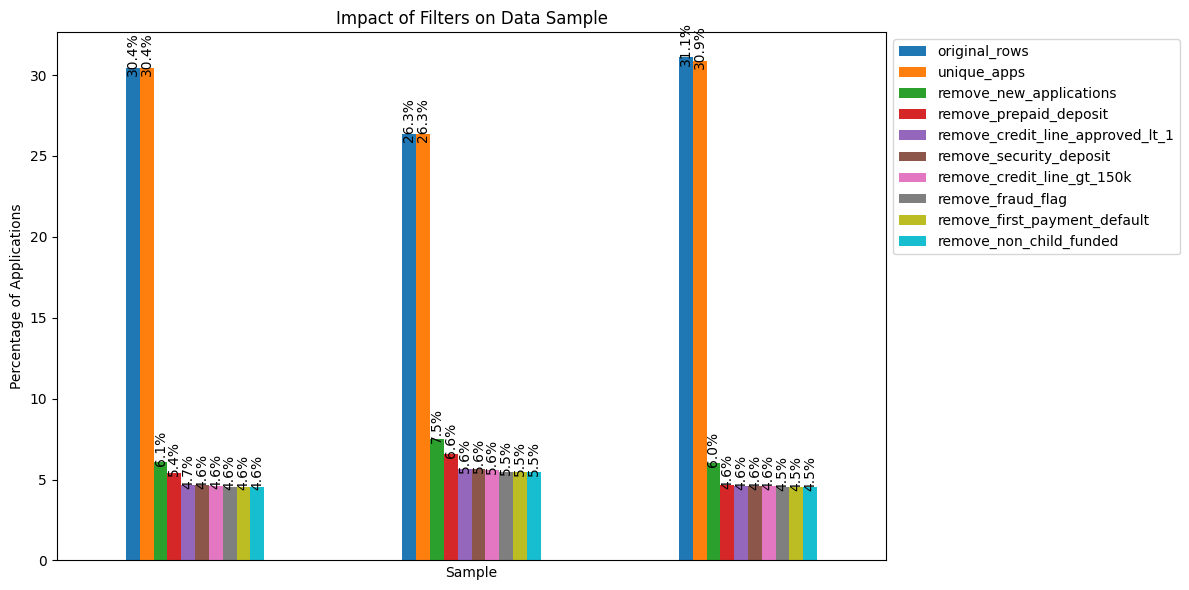

In [14]:
print(f"Original data shape: {merged_df.shape}")
print(f"Filters applied for model development sample: {filters_applied_dev}")
print(f"Filters applied for model application sample: {filters_applied_test}")
print(f"Filters applied for model scoring sample: {filters_applied_scoring}")

mt.filters_applied_chart(filters_applied_dev, filters_applied_test, filters_applied_scoring)

Model development Through the door number of transactions: 7989


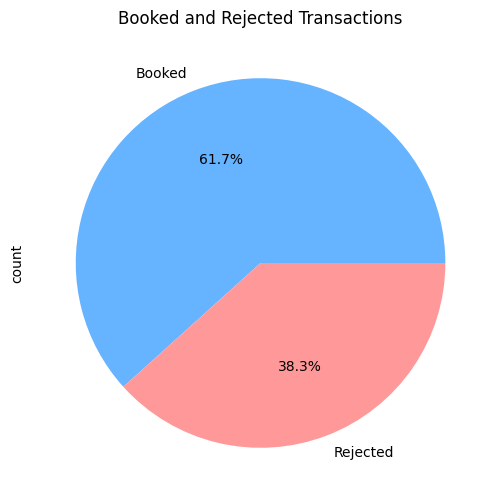

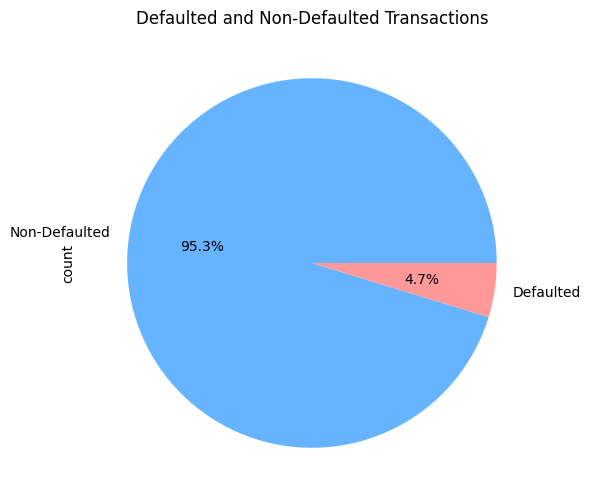

In [15]:
print(f"Model development Through the door number of transactions: {data_dev.shape[0]}")
mt.booked_rejected_pie_chart(data_dev)
mt.default_pie_chart(data_dev)

Model application  Through the door number of transactions: 4033


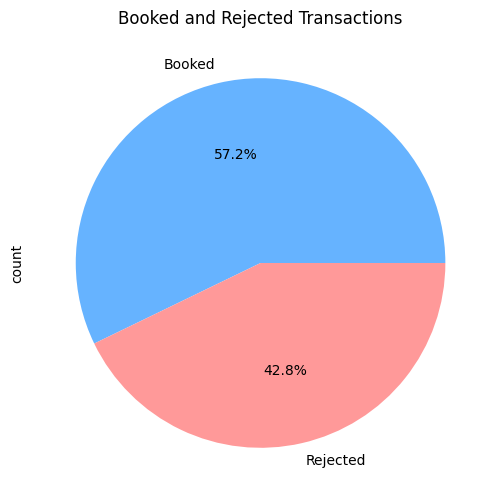

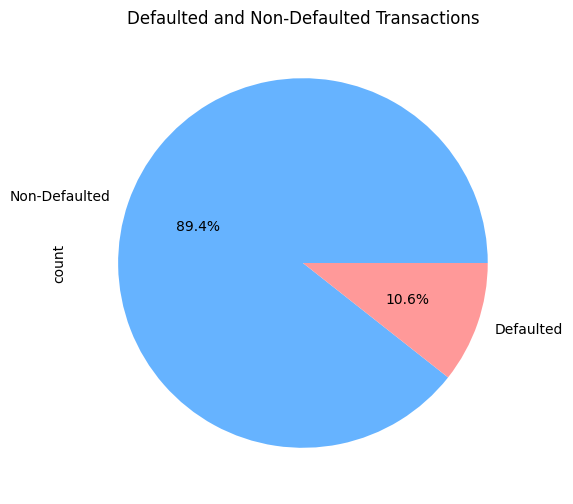

In [16]:
print(f"Model application  Through the door number of transactions: {data_test.shape[0]}")
mt.booked_rejected_pie_chart(data_test)
mt.default_pie_chart(data_test)

Model scoring Through the door number of transactions: 5764


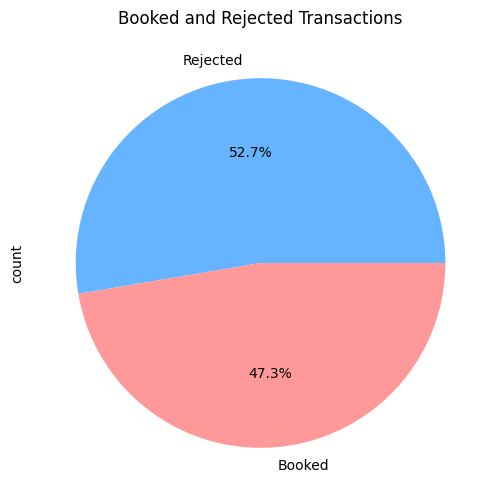

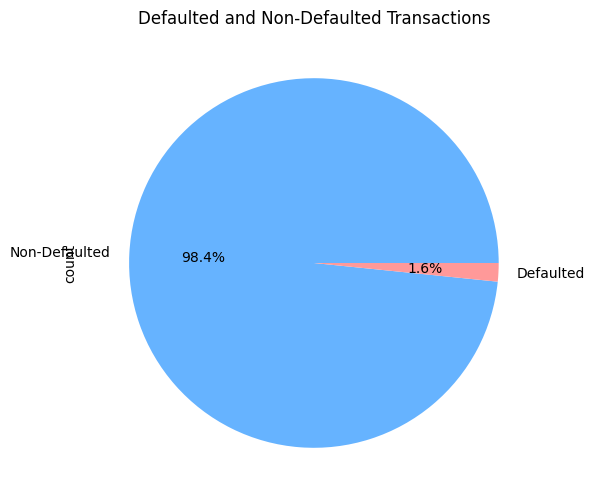

In [17]:
print(f"Model scoring Through the door number of transactions: {data_scoring.shape[0]}")
mt.booked_rejected_pie_chart(data_scoring)
mt.default_pie_chart(data_scoring)

# New Model

In [34]:
conditions = config.CONDITIONS_NEW_MODEL
choices = config.CHOICES_NEW_MODEL
risk_grade_segments = config.RISK_GRADE_SEGMENTS_NEW_MODEL
NORMALIZE_SCORES = config.NORMALIZE_SCORES_NEW_MODEL
new_pd_risk_grade_thresholds = config.NEW_PD_RISK_GRADE_THRESHOLDS
approval_thresholds = config.APPROVAL_THRESHOLDS

# Apply the function to both dataframes
data_dev = mt.apply_risk_grade_path(data_dev, conditions, choices)
data_test = mt.apply_risk_grade_path(data_test, conditions, choices)
data_scoring = mt.apply_risk_grade_path(data_scoring, conditions, choices)
print(len(data_test))
print(len(data_scoring))

4033
5764


In [35]:


# Load the models and normalization parameters
with open('models.pkl', 'rb') as f:
    models_dict = pickle.load(f)

with open('normalization.pkl', 'rb') as f:
    normalization_dict = pickle.load(f)

In [36]:
data_dev_filtered = mt.risk_grade_estimate_preprocessing(data_dev)
data_test_filtered = mt.risk_grade_estimate_preprocessing(data_test)
data_scoring_filtered = mt.risk_grade_estimate_preprocessing(data_scoring)

print(len(data_dev_filtered))

print(data_dev_filtered.risk_grade_path.value_counts())

print(len(data_test_filtered))

print(data_test_filtered.risk_grade_path.value_counts())

print(len(data_scoring_filtered))

print(data_scoring_filtered.risk_grade_path.value_counts())

data_dev_scored = mt.apply_fitted_models_to_data(
    data=data_dev_filtered,
    models_dict=models_dict,
    normalization_dict=normalization_dict,
    RISK_GRADE_SEGMENTS=risk_grade_segments,
    NORMALIZE_SCORES = NORMALIZE_SCORES,
)

data_test_scored = mt.apply_fitted_models_to_data(
    data=data_test_filtered,
    models_dict=models_dict,
    normalization_dict=normalization_dict,
    RISK_GRADE_SEGMENTS=risk_grade_segments,
    NORMALIZE_SCORES = NORMALIZE_SCORES,
)

data_scoring_scored = mt.apply_fitted_models_to_data(
    data=data_scoring_filtered,
    models_dict=models_dict,
    normalization_dict=normalization_dict,
    RISK_GRADE_SEGMENTS=risk_grade_segments,
    NORMALIZE_SCORES = NORMALIZE_SCORES,
)



7989
risk_grade_path
no_pg_and_1_plus_sbfe_tradeline                                               3096
no_pg_and_no_sbfe_tradeline_and_false_1_plus_sba_tradeline_and_fico_no_hit    1726
pg_and_no_sbfe_tradeline_and_no_sba_tradeline_and_fico_hit                    1084
no_pg_and_no_1_plus_sbfe_tradeline_and_1_plus_sba_tradeline                    673
pg_and_1_plus_sbfe_tradeline_and_fico_hit                                      566
no_pg_no_sbfe_no_sba_no_fico                                                   316
pg_and_no_sbfe_tradeline_and_no_sba_tradeline_and_fico_no_hit                  170
pg_and_no_sbfe_tradeline_and_1_plus_sba_tradeline_and_fico_hit                 146
pg_and_1_plus_sbfe_tradeline_and_fico_no_hit                                    95
no_pg_and_no_sbfe_tradeline_and_false_1_plus_sba_tradeline_and_fico_hit         93
pg_and_no_sbfe_tradeline_and_1_plus_sba_tradeline_and_fico_no_hit               24
Name: count, dtype: int64
4033
risk_grade_path
no_pg_and_1_plus_sb

In [37]:
normalization_dict

{'pg_sbfe_ln_and_fico': {'ln_score': {'std': 54.73682089179337,
   'mean': 691.5942440210782},
  'fico_score_filled': {'std': 63.85355451455604, 'mean': 710.1576813944062}},
 'pg_sbfe_ln_only': {'ln_score': {'std': 66.7108709032535,
   'mean': 683.9196787148594}},
 'pg_sba_ln_and_fico': {'ln_score': {'std': 45.731810666248805,
   'mean': 685.5669515669516},
  'fico_score_filled': {'std': 72.54145953802362, 'mean': 647.5356125356126}},
 'pg_sba_ln_only': {'ln_score': {'std': 49.14940760198726,
   'mean': 674.6178861788618}},
 'pg_fico_only': {'fico_score': {'std': 74.20708340100364,
   'mean': 678.3740901133327}},
 'pg_no_hits': {},
 'no_pg_sbfe_ln_only': {'ln_score': {'std': 62.03816399637875,
   'mean': 695.6245081506464}},
 'no_pg_sba_ln_only': {'ln_score': {'std': 50.57822613372447,
   'mean': 682.0095124851367}},
 'no_pg_no_hits': {},
 'no_pg_false_sba_fico_hit': {},
 'no_pg_false_sba_no_hits': {}}

### Booking and predicted booking tables

In [38]:
data_dev_scored['pg_subsegment'] = np.where((data_dev_scored['number_of_trucks_c'] <= 7) | (data_dev_scored['years_in_business_num_c'] <= 3), 'pg_should_be_required', 'pg_should_not_be_required')
data_test_scored['pg_subsegment'] = np.where((data_test_scored['number_of_trucks_c'] <= 7) | (data_test_scored['years_in_business_num_c'] <= 3), 'pg_should_be_required', 'pg_should_not_be_required')
data_scoring_scored['pg_subsegment'] = np.where((data_scoring_scored['number_of_trucks_c'] <= 7) | (data_scoring_scored['years_in_business_num_c'] <= 3), 'pg_should_be_required', 'pg_should_not_be_required')

In [39]:
PG_SUBSEGMENTS = {
    "pg_should_be_required": {"condition": {"column": "pg_subsegment", "allowed_values": ["pg_should_be_required"]}},
    "pg_should_not_be_required": {"condition": {"column": "pg_subsegment", "allowed_values": ["pg_should_not_be_required"]}}
}

In [47]:

# Training: Calculate segment statistics with approval/decline thresholds
segment_stats_df = mt.calculate_segment_statistics_with_approval(
    data=data_dev_scored,
    RISK_GRADE_SEGMENTS=risk_grade_segments,
    risk_grade_thresholds=new_pd_risk_grade_thresholds,
    approval_thresholds=approval_thresholds,
    PG_SUBSEGMENTS=PG_SUBSEGMENTS,
)

# Display the results
# print(segment_stats_df)


# Test: Calculate segment statistics with approval/decline thresholds
segment_stats_df = mt.calculate_segment_statistics_with_approval(
    data=data_test_scored,
    RISK_GRADE_SEGMENTS=risk_grade_segments,
    risk_grade_thresholds=new_pd_risk_grade_thresholds,
    approval_thresholds=approval_thresholds,
    PG_SUBSEGMENTS=PG_SUBSEGMENTS,
)

# # Display the results
# print(segment_stats_df)

# Current: 
segment_stats_df = mt.calculate_segment_statistics_with_approval(
    data=data_scoring_scored,
    RISK_GRADE_SEGMENTS=risk_grade_segments,
    risk_grade_thresholds=new_pd_risk_grade_thresholds,
    approval_thresholds=approval_thresholds,
    PG_SUBSEGMENTS=PG_SUBSEGMENTS,
)

# # Display the results
# print(segment_stats_df)

segment_stats_df

,segment_name,total_rows,num_booked,num_non_booked,booked_is_bad,predicted_booked,predicted_booked_is_bad,predicted_declined,min_number_of_trucks,max_number_of_trucks,avg_number_of_trucks,min_years_in_business,max_years_in_business,avg_years_in_business,subsegment_name
0,pg_sbfe_ln_and_fico,1847,998,849,12,1236,7,611,0.0,44.0,2.470493,1.0,108.0,7.687060,pg_should_be_required
1,pg_sbfe_ln_and_fico,24,14,10,0,19,0,5,8.0,50.0,17.500000,4.0,4.0,4.000000,pg_should_not_be_required
2,pg_sbfe_ln_only,455,231,224,4,352,3,103,0.0,18.0,2.643956,1.0,65.0,8.696703,pg_should_be_required
3,pg_sbfe_ln_only,6,4,2,0,6,0,0,9.0,95.0,34.833333,4.0,27.0,7.833333,pg_should_not_be_required
4,pg_sba_ln_and_fico,250,71,179,1,62,0,188,1.0,8.0,2.428000,1.0,27.0,5.560000,pg_should_be_required
5,pg_sba_ln_and_fico,6,1,5,0,1,0,5,8.0,20.0,10.333333,4.0,4.0,4.000000,pg_should_not_be_required
6,pg_sba_ln_only,70,19,51,1,0,0,70,1.0,7.0,2.214286,1.0,21.0,5.757143,pg_should_be_required
7,pg_sba_ln_only,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,pg_should_not_be_required
8,pg_fico_only,1848,766,1082,11,933,10,915,0.0,150.0,2.192100,1.0,325.0,5.360390,pg_should_be_required
9,pg_fico_only,28,10,18,1,16,1,12,8.0,115.0,20.500000,4.0,69.0,11.071429,pg_should_not_be_required


In [26]:
data_scoring_filtered[data_scoring_filtered['risk_grade_path'] == 'nan'].head()

,application_number,ar_id,booked,decision_date,number_of_trucks_c,program_group,product_type_c,fraud_flag_c,existing_exposure_check_c,credit_line_requested_c,...,D_DAYS_SINCE_LAST_1_DPD,existing_exposure,n_acc_group,risk_grade_path,has_fico,intercept,no_fico,fico_score_filled,ln_score_filled,no_ln


#### AUC - PR AUC

In [27]:

df_performance = data_test_scored.copy()
df_performance['segment'] = df_performance['risk_grade_path'].replace({'double_no_hit': 'no_hit_unknown', 'UNKNOWN': 'no_hit_unknown'})

# Calculate segment counts
segment_counts = df_performance['segment'].value_counts()

# Initialize dictionaries to store AUC and PR-AUC results
auc_results = {}
prauc_results = {}

for segment in df_performance['segment'].unique():
    segment_data = df_performance[df_performance['segment'] == segment]

    if segment == 'pg_and_1_plus_sbfe_tradeline_and_fico_hit':
        y_true = (segment_data['is_bad']).astype(int)  # Convert boolean to integer
        y_score = segment_data['pd_pg_sbfe_ln_and_fico']
        
    elif segment == 'pg_and_1_plus_sbfe_tradeline_and_fico_no_hit':
        y_true = (segment_data['is_bad']).astype(int)
        y_score = segment_data['pd_pg_sbfe_ln_only']

    elif segment == 'pg_and_no_sbfe_tradeline_and_1_plus_sba_tradeline_and_fico_hit':
        y_true = (segment_data['is_bad']).astype(int)
        y_score = segment_data['pd_pg_sba_ln_and_fico']

    elif segment == 'pg_and_no_sbfe_tradeline_and_1_plus_sba_tradeline_and_fico_no_hit':
        y_true = (segment_data['is_bad']).astype(int)
        y_score = segment_data['pd_pg_sba_ln_only']

    elif segment == 'pg_and_no_sbfe_tradeline_and_no_sba_tradeline_and_fico_hit':
        y_true = (segment_data['is_bad']).astype(int)
        y_score = segment_data['pd_pg_fico_only']

    elif segment == 'pg_and_no_sbfe_tradeline_and_no_sba_tradeline_and_fico_no_hit':
        segment_data = segment_data.dropna(subset=['pd_pg_no_hits'])
        y_true = (segment_data['is_bad']).astype(int)
        y_score = segment_data['pd_pg_no_hits']

    elif segment == 'no_pg_and_1_plus_sbfe_tradeline':
        y_true = (segment_data['is_bad']).astype(int)
        y_score = segment_data['pd_no_pg_sbfe_ln_only']

    elif segment == 'no_pg_and_no_1_plus_sbfe_tradeline_and_1_plus_sba_tradeline':
        y_true = (segment_data['is_bad']).astype(int)
        y_score = segment_data['pd_no_pg_sba_ln_only']

    elif segment == 'no_pg_no_sbfe_no_sba_no_fico':
        y_true = (segment_data['is_bad']).astype(int)
        y_score = segment_data['pd_no_pg_no_hits']

    elif segment == 'no_pg_and_no_sbfe_tradeline_and_false_1_plus_sba_tradeline_and_fico_hit':
        y_true = (segment_data['is_bad']).astype(int)
        y_score = segment_data['pd_no_pg_false_sba_fico_hit']

    elif segment == 'no_pg_and_no_sbfe_tradeline_and_false_1_plus_sba_tradeline_and_fico_no_hit':
        y_true = (segment_data['is_bad']).astype(int)
        y_score = segment_data['pd_no_pg_false_sba_no_hits']

    else:
        continue

    auc = roc_auc_score(y_true, y_score)
    auc_results[segment] = auc

    prauc = average_precision_score(y_true, y_score)
    prauc_results[segment] = prauc


# Print the results
print("Segment Counts:\n", segment_counts)
print("\nAUC Results:\n", auc_results)
print("\nPR-AUC Results:\n", prauc_results)

ValueError: Only one class present in y_true. ROC AUC score is not defined in that case.

## Lift Charts

#### pd_pg_sbfe_ln_and_fico

g:\My Drive\projects\otr_adjudication\otr_ln_master_table\otr_ln_master_table\otr_ln_master_table\notebooks\..\resources\model_training.py:913: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
g:\My Drive\projects\otr_adjudication\otr_ln_master_table\otr_ln_master_table\otr_ln_master_table\notebooks\..\resources\model_training.py:913: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
g:\My Drive\projects\otr_adjudication\otr_ln_master_table\otr_ln_master_table\otr_ln_master_table\notebooks\..\resources\model_training.py:913: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
g:\My Drive\projects\otr_adjudication\otr_ln_master_table\otr_ln_master_table\otr_ln_master_table\notebook

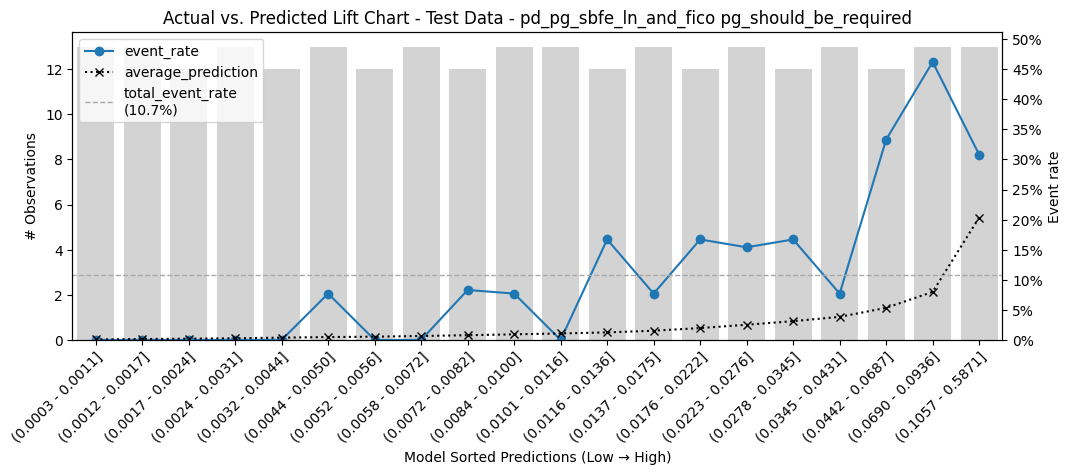

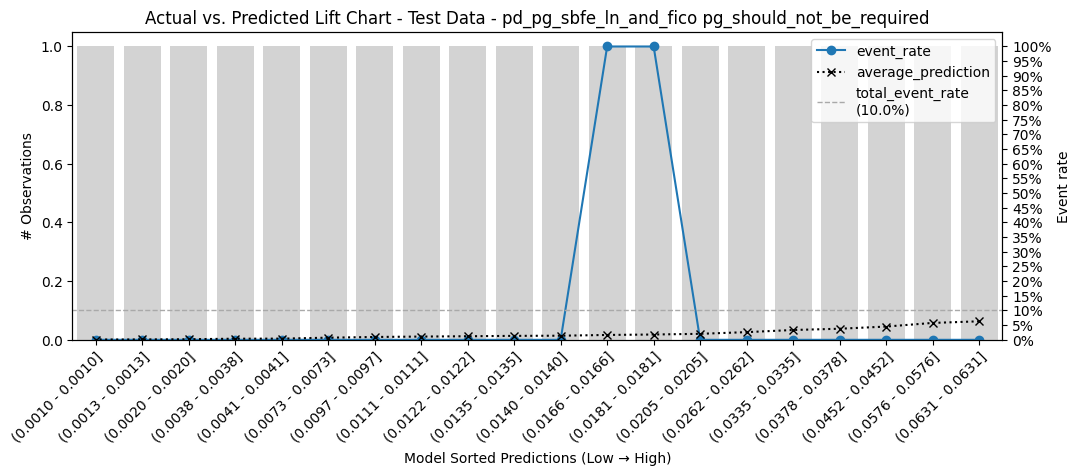

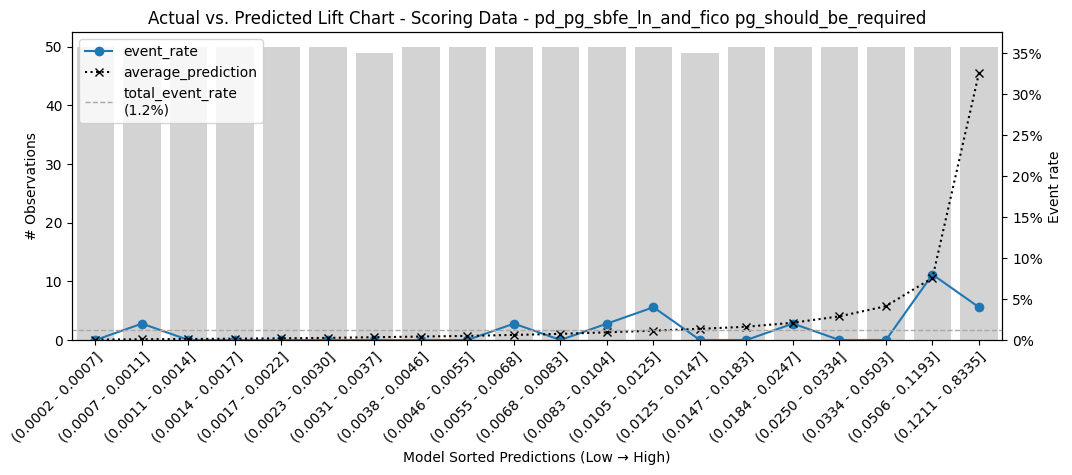

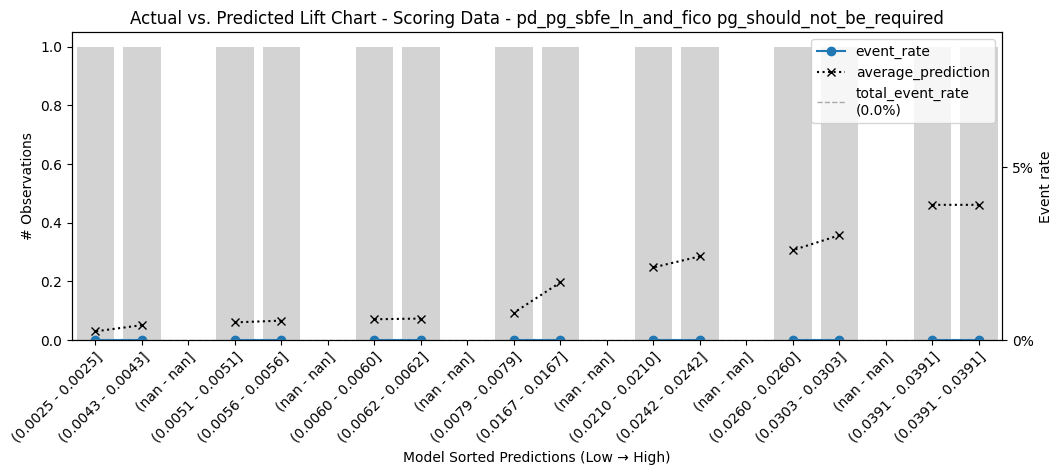

In [33]:
# pd_pg_sbfe_ln_and_fico, test data and subsegment pg_should_be_required
mt.lift_chart_plot('Test Data - pd_pg_sbfe_ln_and_fico pg_should_be_required', mt.compute_decile_table(
        data_test_scored[(data_test_scored['booked']) & (data_test_scored['pg_subsegment'] == 'pg_should_be_required')], 
        'pd_pg_sbfe_ln_and_fico',
        'is_bad',
        20,
        'pg_and_1_plus_sbfe_tradeline_and_fico_hit'
), 'PROB_RANGE')

# pd_pg_sbfe_ln_and_fico, test data and subsegment pg_should_not_be_required
mt.lift_chart_plot('Test Data - pd_pg_sbfe_ln_and_fico pg_should_not_be_required', mt.compute_decile_table(
        data_test_scored[(data_test_scored['booked']) & (data_test_scored['pg_subsegment'] == 'pg_should_not_be_required')], 
        'pd_pg_sbfe_ln_and_fico',
        'is_bad',
        20,
        'pg_and_1_plus_sbfe_tradeline_and_fico_hit'
), 'PROB_RANGE')

# pd_pg_sbfe_ln_and_fico, scoring data and subsegment pg_should_be_required
mt.lift_chart_plot('Scoring Data - pd_pg_sbfe_ln_and_fico pg_should_be_required', mt.compute_decile_table(
        data_scoring_scored[(data_scoring_scored['booked']) & (data_scoring_scored['pg_subsegment'] == 'pg_should_be_required')], 
        'pd_pg_sbfe_ln_and_fico',
        'is_bad',
        20,
        'pg_and_1_plus_sbfe_tradeline_and_fico_hit'
), 'PROB_RANGE')


# pd_pg_sbfe_ln_and_fico, scoring data and subsegment pg_should_not_be_required
mt.lift_chart_plot('Scoring Data - pd_pg_sbfe_ln_and_fico pg_should_not_be_required', mt.compute_decile_table(
        data_scoring_scored[(data_scoring_scored['booked']) & (data_scoring_scored['pg_subsegment'] == 'pg_should_not_be_required')], 
        'pd_pg_sbfe_ln_and_fico',
        'is_bad',
        20,
        'pg_and_1_plus_sbfe_tradeline_and_fico_hit'
), 'PROB_RANGE')

##### Risk Grade Lift Chart

g:\My Drive\projects\otr_adjudication\otr_ln_master_table\otr_ln_master_table\otr_ln_master_table\notebooks\..\resources\model_training.py:913: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
g:\My Drive\projects\otr_adjudication\otr_ln_master_table\otr_ln_master_table\otr_ln_master_table\notebooks\..\resources\model_training.py:913: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
g:\My Drive\projects\otr_adjudication\otr_ln_master_table\otr_ln_master_table\otr_ln_master_table\notebooks\..\resources\model_training.py:913: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
g:\My Drive\projects\otr_adjudication\otr_ln_master_table\otr_ln_master_table\otr_ln_master_table\notebook

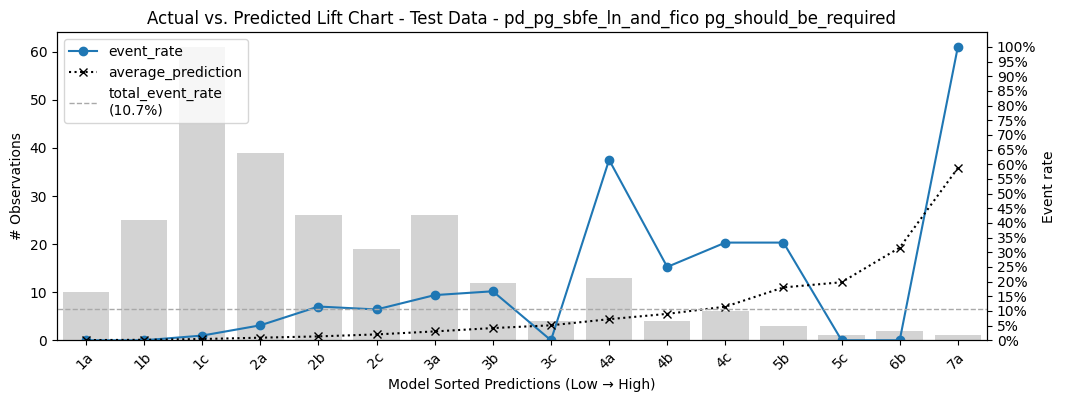

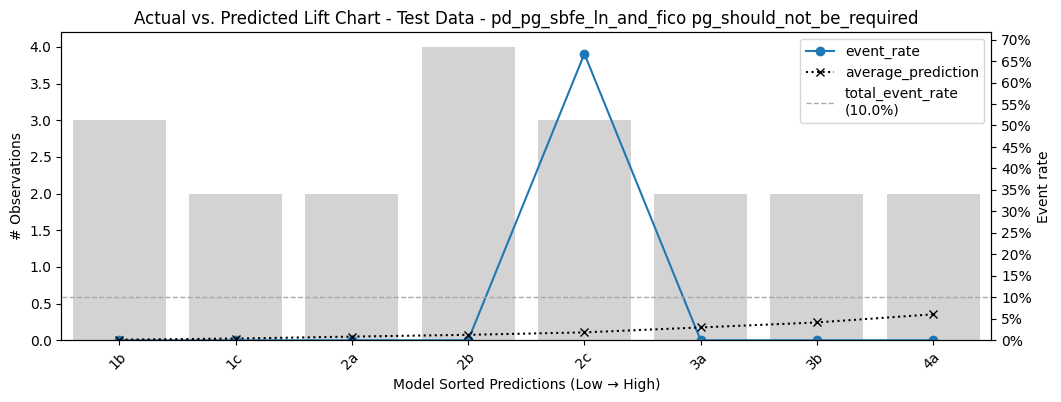

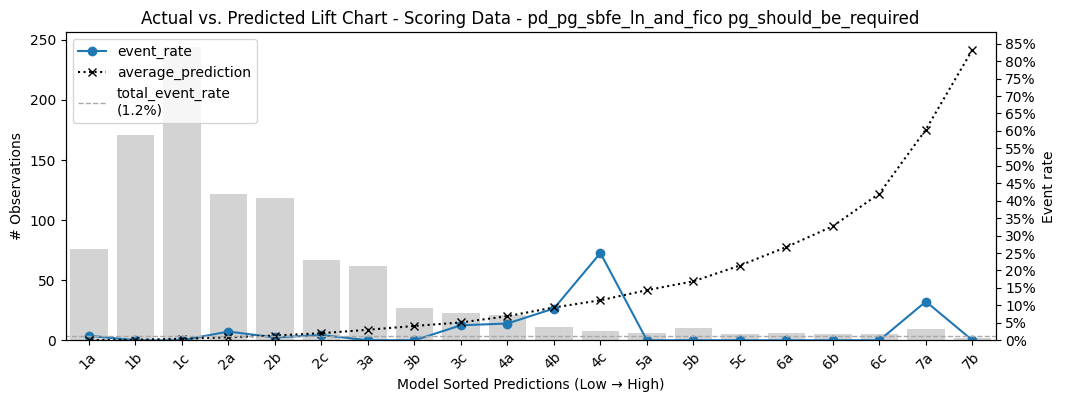

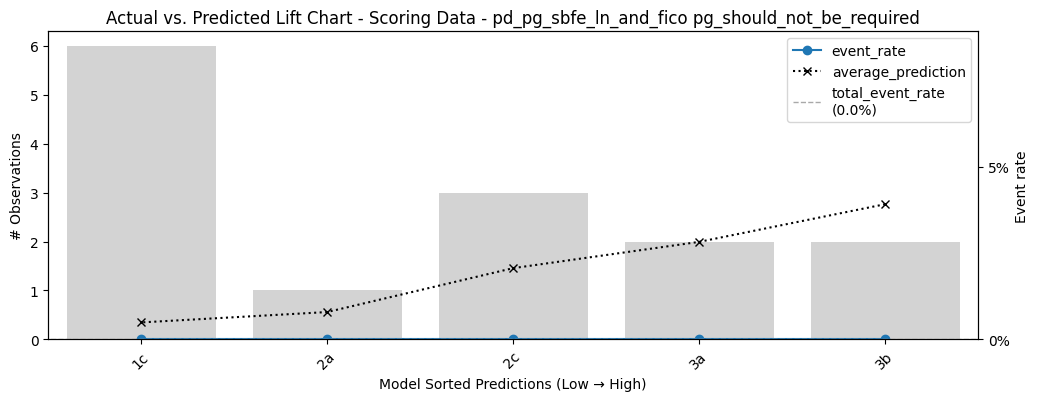

In [48]:
# pd_pg_sbfe_ln_and_fico, dev data and subsegment pg_should_be_required
data = data_test_scored.copy()
data['risk_grades'] = data[(data['booked']) & (data['risk_grade_path'] == 'pg_and_1_plus_sbfe_tradeline_and_fico_hit') & (data['pg_subsegment'] == 'pg_should_be_required')]['pd_pg_sbfe_ln_and_fico'].apply(lambda x: mt.assign_risk_grade(x, new_pd_risk_grade_thresholds))

mt.lift_chart_plot('Test Data - pd_pg_sbfe_ln_and_fico pg_should_be_required',mt.compute_risk_grade_table(
        data[data['booked'] & (data['pg_subsegment'] == 'pg_should_be_required')],
        'pd_pg_sbfe_ln_and_fico',
        'is_bad',
        20,
        'pg_and_1_plus_sbfe_tradeline_and_fico_hit',
        'risk_grades'
), 'risk_grades')



# pd_pg_sbfe_ln_and_fico, dev data and subsegment pg_should_not_be_required
data = data_test_scored.copy()
data['risk_grades'] = data[(data['booked']) & (data['risk_grade_path'] == 'pg_and_1_plus_sbfe_tradeline_and_fico_hit') & (data['pg_subsegment'] == 'pg_should_not_be_required')]['pd_pg_sbfe_ln_and_fico'].apply(lambda x: mt.assign_risk_grade(x, new_pd_risk_grade_thresholds))

mt.lift_chart_plot('Test Data - pd_pg_sbfe_ln_and_fico pg_should_not_be_required',mt.compute_risk_grade_table(
        data[data['booked'] & (data['pg_subsegment'] == 'pg_should_not_be_required')],
        'pd_pg_sbfe_ln_and_fico',
        'is_bad',
        20,
        'pg_and_1_plus_sbfe_tradeline_and_fico_hit',
        'risk_grades'
), 'risk_grades')

# pd_pg_sbfe_ln_and_fico, scoring data and subsegment pg_should_be_required
data = data_scoring_scored.copy()
data['risk_grades'] = data[(data['booked']) & (data['risk_grade_path'] == 'pg_and_1_plus_sbfe_tradeline_and_fico_hit') & (data['pg_subsegment'] == 'pg_should_be_required')]['pd_pg_sbfe_ln_and_fico'].apply(lambda x: mt.assign_risk_grade(x, new_pd_risk_grade_thresholds))

mt.lift_chart_plot('Scoring Data - pd_pg_sbfe_ln_and_fico pg_should_be_required',mt.compute_risk_grade_table(
        data[data['booked'] & (data['pg_subsegment'] == 'pg_should_be_required')],
        'pd_pg_sbfe_ln_and_fico',
        'is_bad',
        20,
        'pg_and_1_plus_sbfe_tradeline_and_fico_hit',
        'risk_grades'
), 'risk_grades')

# pd_pg_sbfe_ln_and_fico, scoring data and subsegment pg_should_not_be_required
data = data_scoring_scored.copy()
data['risk_grades'] = data[(data['booked']) & (data['risk_grade_path'] == 'pg_and_1_plus_sbfe_tradeline_and_fico_hit') & (data['pg_subsegment'] == 'pg_should_not_be_required')]['pd_pg_sbfe_ln_and_fico'].apply(lambda x: mt.assign_risk_grade(x, new_pd_risk_grade_thresholds))

mt.lift_chart_plot('Scoring Data - pd_pg_sbfe_ln_and_fico pg_should_not_be_required',mt.compute_risk_grade_table(
        data[data['booked'] & (data['pg_subsegment'] == 'pg_should_not_be_required')],
        'pd_pg_sbfe_ln_and_fico',
        'is_bad',
        20,
        'pg_and_1_plus_sbfe_tradeline_and_fico_hit',
        'risk_grades'
), 'risk_grades')


#### pd_pg_sbfe_ln_only

g:\My Drive\projects\otr_adjudication\otr_ln_master_table\otr_ln_master_table\otr_ln_master_table\notebooks\..\resources\model_training.py:913: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
g:\My Drive\projects\otr_adjudication\otr_ln_master_table\otr_ln_master_table\otr_ln_master_table\notebooks\..\resources\model_training.py:913: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
g:\My Drive\projects\otr_adjudication\otr_ln_master_table\otr_ln_master_table\otr_ln_master_table\notebooks\..\resources\model_training.py:913: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
g:\My Drive\projects\otr_adjudication\otr_ln_master_table\otr_ln_master_table\otr_ln_master_table\notebook

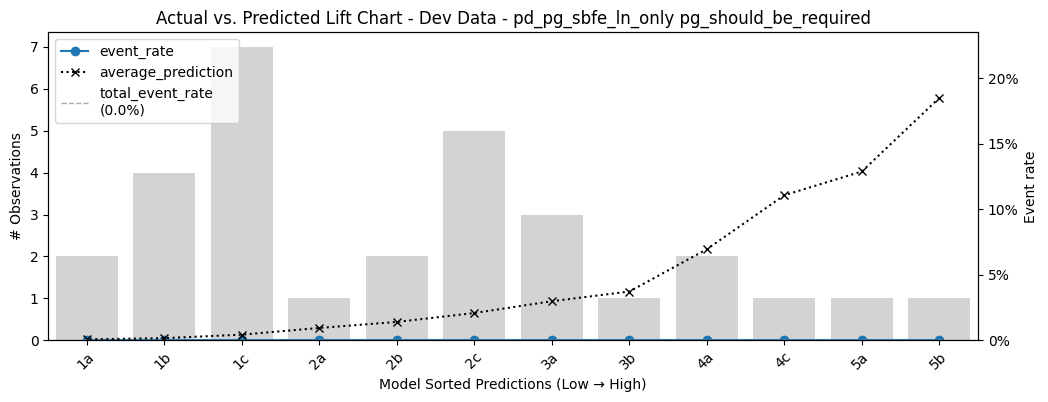

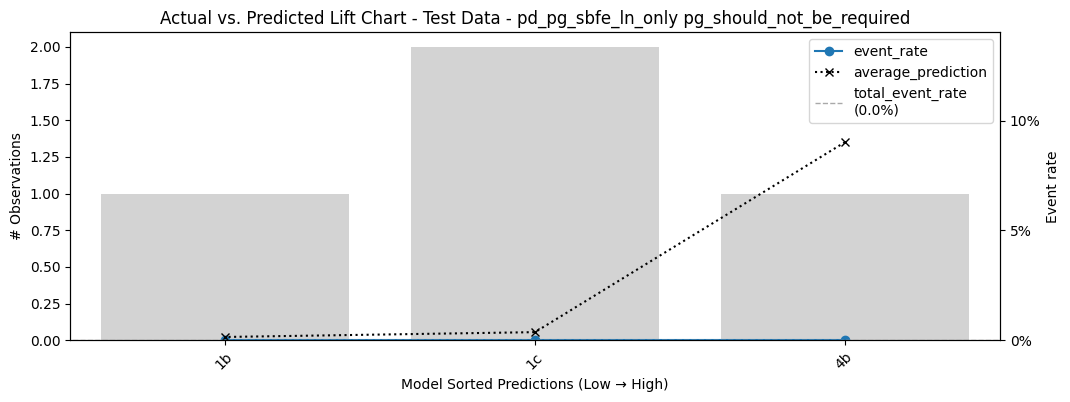

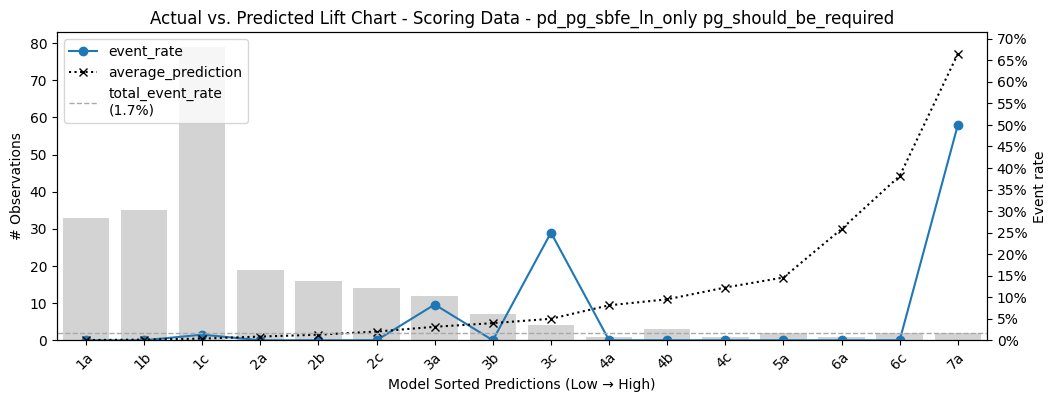

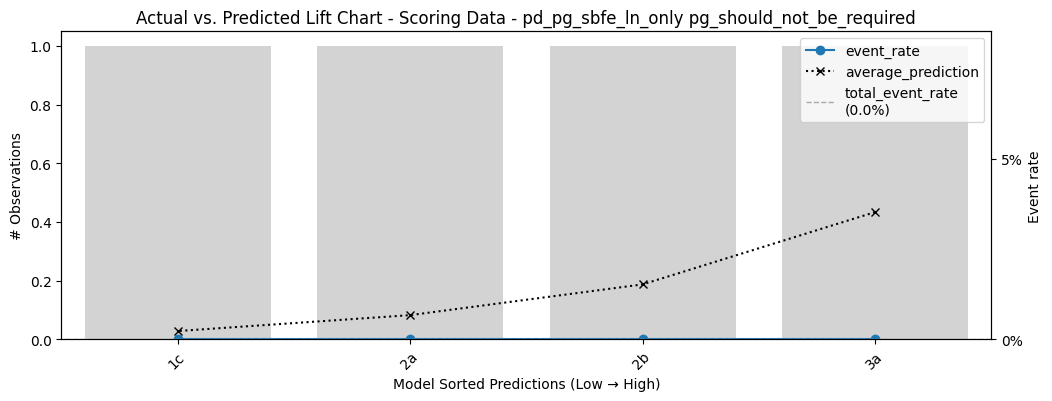

In [49]:
# pd_pg_sbfe_ln_only, dev data and subsegment pg_should_be_required
data = data_dev_scored.copy()
data['risk_grades'] = data[(data['booked']) & (data['risk_grade_path'] == 'pg_and_1_plus_sbfe_tradeline_and_fico_no_hit')]['pd_pg_sbfe_ln_only'].apply(lambda x: mt.assign_risk_grade(x, new_pd_risk_grade_thresholds))

mt.lift_chart_plot('Dev Data - pd_pg_sbfe_ln_only pg_should_be_required',mt.compute_risk_grade_table(
        data[data['booked'] & (data['pg_subsegment'] == 'pg_should_be_required')],
        'pd_pg_sbfe_ln_only',
        'is_bad',
        20,
        'pg_and_1_plus_sbfe_tradeline_and_fico_no_hit',
        'risk_grades'
), 'risk_grades')


# pd_pg_sbfe_ln_only, dev data and subsegment pg_should_not_be_required
data = data_test_scored.copy()
data['risk_grades'] = data[(data['booked']) & (data['risk_grade_path'] == 'pg_and_1_plus_sbfe_tradeline_and_fico_no_hit')]['pd_pg_sbfe_ln_only'].apply(lambda x: mt.assign_risk_grade(x, new_pd_risk_grade_thresholds))

mt.lift_chart_plot('Test Data - pd_pg_sbfe_ln_only pg_should_not_be_required',mt.compute_risk_grade_table(
        data[data['booked'] & (data['pg_subsegment'] == 'pg_should_not_be_required')],
        'pd_pg_sbfe_ln_only',
        'is_bad',
        20,
        'pg_and_1_plus_sbfe_tradeline_and_fico_no_hit',
        'risk_grades'
), 'risk_grades')



# pd_pg_sbfe_ln_only, scoring data and subsegment pg_should_be_required
data = data_scoring_scored.copy()
data['risk_grades'] = data[(data['booked']) & (data['risk_grade_path'] == 'pg_and_1_plus_sbfe_tradeline_and_fico_no_hit')]['pd_pg_sbfe_ln_only'].apply(lambda x: mt.assign_risk_grade(x, new_pd_risk_grade_thresholds))

mt.lift_chart_plot('Scoring Data - pd_pg_sbfe_ln_only pg_should_be_required',mt.compute_risk_grade_table(
        data[data['booked'] & (data['pg_subsegment'] == 'pg_should_be_required')],
        'pd_pg_sbfe_ln_only',
        'is_bad',
        20,
        'pg_and_1_plus_sbfe_tradeline_and_fico_no_hit',
        'risk_grades'
), 'risk_grades')

# pd_pg_sbfe_ln_only, scoring data and subsegment pg_should_not_be_required
data = data_scoring_scored.copy()
data['risk_grades'] = data[(data['booked']) & (data['risk_grade_path'] == 'pg_and_1_plus_sbfe_tradeline_and_fico_no_hit')]['pd_pg_sbfe_ln_only'].apply(lambda x: mt.assign_risk_grade(x, new_pd_risk_grade_thresholds))

mt.lift_chart_plot('Scoring Data - pd_pg_sbfe_ln_only pg_should_not_be_required',mt.compute_risk_grade_table(
        data[data['booked'] & (data['pg_subsegment'] == 'pg_should_not_be_required')],
        'pd_pg_sbfe_ln_only',
        'is_bad',
        20,
        'pg_and_1_plus_sbfe_tradeline_and_fico_no_hit',
        'risk_grades'
), 'risk_grades')



#### pd_pg_sba_ln_and_fico

g:\My Drive\projects\otr_adjudication\otr_ln_master_table\otr_ln_master_table\otr_ln_master_table\notebooks\..\resources\model_training.py:913: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
g:\My Drive\projects\otr_adjudication\otr_ln_master_table\otr_ln_master_table\otr_ln_master_table\notebooks\..\resources\model_training.py:913: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
g:\My Drive\projects\otr_adjudication\otr_ln_master_table\otr_ln_master_table\otr_ln_master_table\notebooks\..\resources\model_training.py:913: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
g:\My Drive\projects\otr_adjudication\otr_ln_master_table\otr_ln_master_table\otr_ln_master_table\notebook

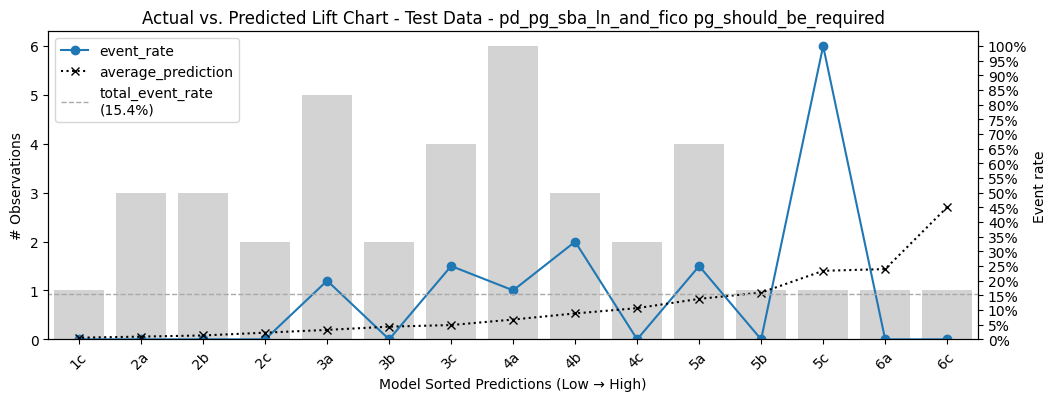

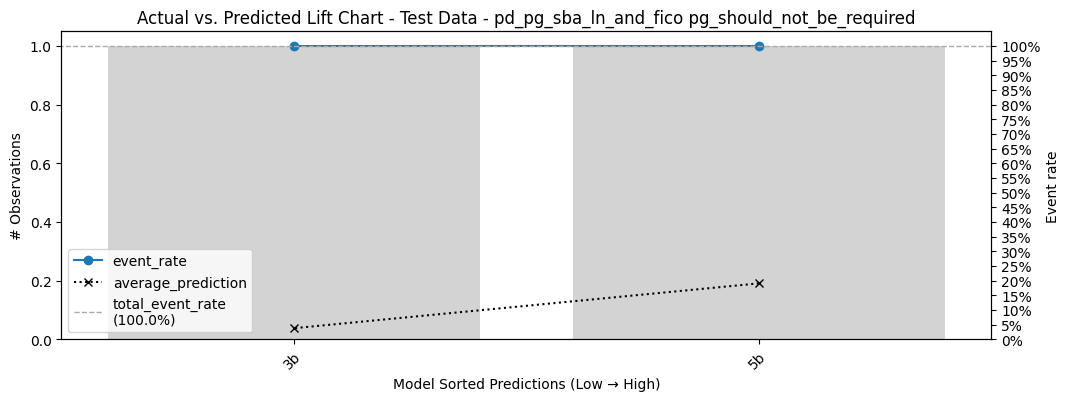

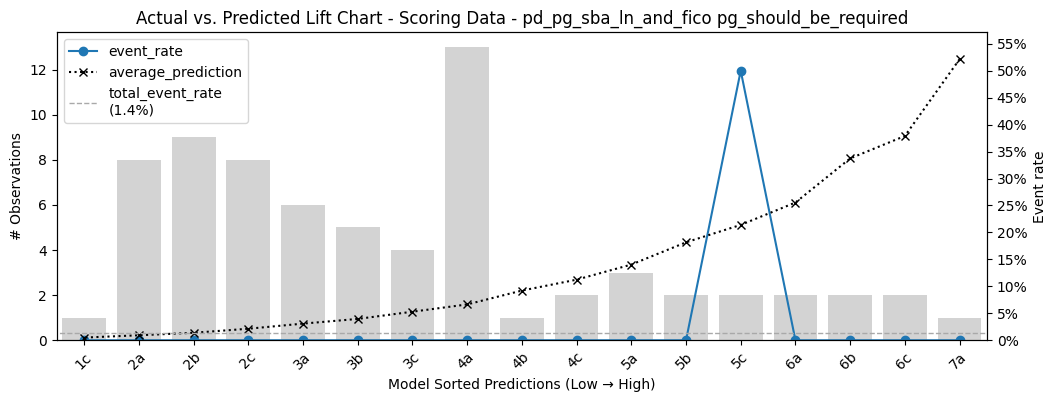

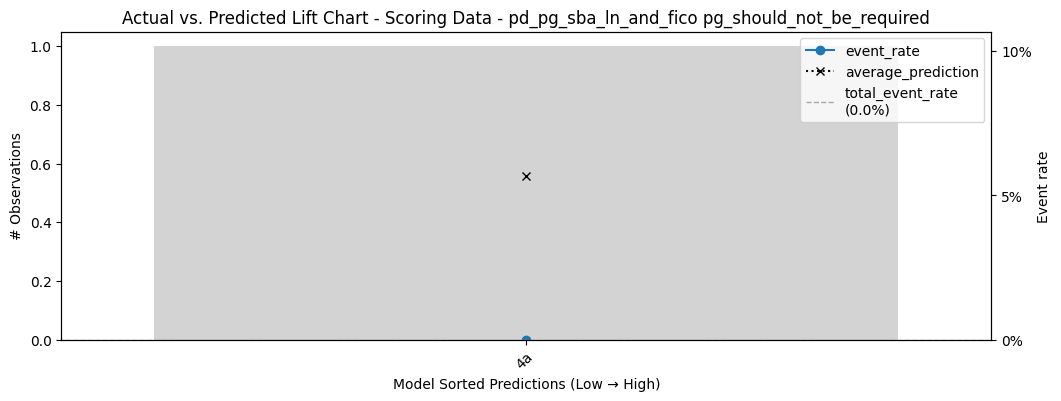

In [50]:
# pd_pg_sba_ln_and_fico, dev data and subsegment pg_should_be_required
data = data_test_scored.copy()
data['risk_grades'] = data[(data['booked']) & (data['risk_grade_path'] == 'pg_and_no_sbfe_tradeline_and_1_plus_sba_tradeline_and_fico_hit')]['pd_pg_sba_ln_and_fico'].apply(lambda x: mt.assign_risk_grade(x, new_pd_risk_grade_thresholds))

mt.lift_chart_plot('Test Data - pd_pg_sba_ln_and_fico pg_should_be_required',mt.compute_risk_grade_table(
        data[data['booked'] & (data['pg_subsegment'] == 'pg_should_be_required')],
        'pd_pg_sba_ln_and_fico',
        'is_bad',
        20,
        'pg_and_no_sbfe_tradeline_and_1_plus_sba_tradeline_and_fico_hit',
        'risk_grades'
), 'risk_grades')


# pd_pg_sba_ln_and_fico, dev data and subsegment pg_should_not_be_required
data = data_test_scored.copy()
data['risk_grades'] = data[(data['booked']) & (data['risk_grade_path'] == 'pg_and_no_sbfe_tradeline_and_1_plus_sba_tradeline_and_fico_hit')]['pd_pg_sba_ln_and_fico'].apply(lambda x: mt.assign_risk_grade(x, new_pd_risk_grade_thresholds))

mt.lift_chart_plot('Test Data - pd_pg_sba_ln_and_fico pg_should_not_be_required',mt.compute_risk_grade_table(
        data[data['booked'] & (data['pg_subsegment'] == 'pg_should_not_be_required')],
        'pd_pg_sba_ln_and_fico',
        'is_bad',
        20,
        'pg_and_no_sbfe_tradeline_and_1_plus_sba_tradeline_and_fico_hit',
        'risk_grades'
), 'risk_grades')

# pd_pg_sba_ln_and_fico, scoring data and subsegment pg_should_be_required
data = data_scoring_scored.copy()
data['risk_grades'] = data[(data['booked']) & (data['risk_grade_path'] == 'pg_and_no_sbfe_tradeline_and_1_plus_sba_tradeline_and_fico_hit')]['pd_pg_sba_ln_and_fico'].apply(lambda x: mt.assign_risk_grade(x, new_pd_risk_grade_thresholds))

mt.lift_chart_plot('Scoring Data - pd_pg_sba_ln_and_fico pg_should_be_required',mt.compute_risk_grade_table(
        data[data['booked'] & (data['pg_subsegment'] == 'pg_should_be_required')],
        'pd_pg_sba_ln_and_fico',
        'is_bad',
        20,
        'pg_and_no_sbfe_tradeline_and_1_plus_sba_tradeline_and_fico_hit',
        'risk_grades'
), 'risk_grades')

# pd_pg_sba_ln_and_fico, scoring data and subsegment pg_should_not_be_required
data = data_scoring_scored.copy()
data['risk_grades'] = data[(data['booked']) & (data['risk_grade_path'] == 'pg_and_no_sbfe_tradeline_and_1_plus_sba_tradeline_and_fico_hit')]['pd_pg_sba_ln_and_fico'].apply(lambda x: mt.assign_risk_grade(x, new_pd_risk_grade_thresholds))

mt.lift_chart_plot('Scoring Data - pd_pg_sba_ln_and_fico pg_should_not_be_required',mt.compute_risk_grade_table(
        data[data['booked'] & (data['pg_subsegment'] == 'pg_should_not_be_required')],
        'pd_pg_sba_ln_and_fico',
        'is_bad',
        20,
        'pg_and_no_sbfe_tradeline_and_1_plus_sba_tradeline_and_fico_hit',
        'risk_grades'
), 'risk_grades')


#### pd_pg_sba_ln_only

g:\My Drive\projects\otr_adjudication\otr_ln_master_table\otr_ln_master_table\otr_ln_master_table\notebooks\..\resources\model_training.py:913: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
g:\My Drive\projects\otr_adjudication\otr_ln_master_table\otr_ln_master_table\otr_ln_master_table\notebooks\..\resources\model_training.py:913: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


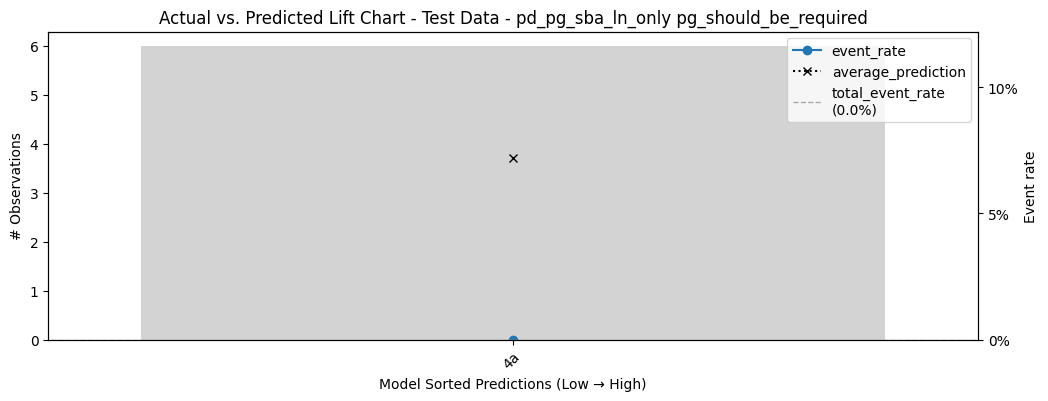

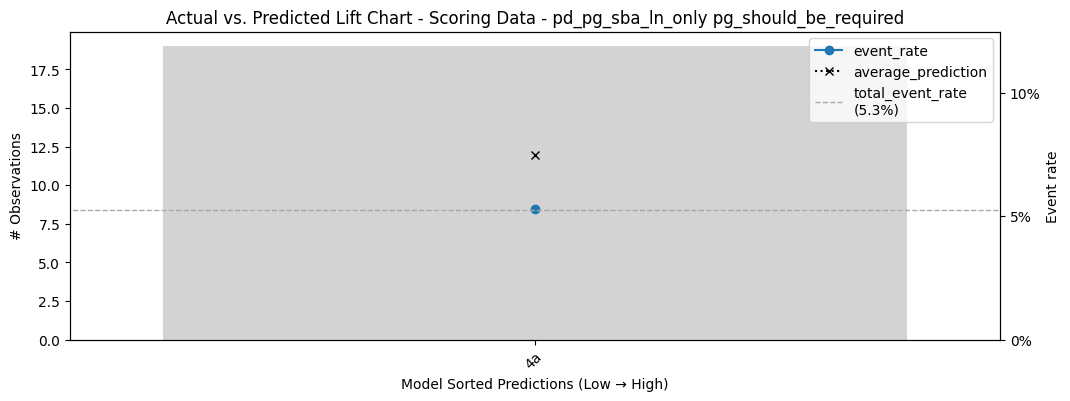

In [52]:
# pd_pg_sba_ln_only, dev data and subsegment pg_should_be_required
data = data_test_scored.copy()
data['risk_grades'] = data[(data['booked']) & (data['risk_grade_path'] == 'pg_and_no_sbfe_tradeline_and_1_plus_sba_tradeline_and_fico_no_hit')]['pd_pg_sba_ln_only'].apply(lambda x: mt.assign_risk_grade(x, new_pd_risk_grade_thresholds))

mt.lift_chart_plot('Test Data - pd_pg_sba_ln_only pg_should_be_required',mt.compute_risk_grade_table(
        data[data['booked'] & (data['pg_subsegment'] == 'pg_should_be_required')],
        'pd_pg_sba_ln_only',
        'is_bad',
        20,
        'pg_and_no_sbfe_tradeline_and_1_plus_sba_tradeline_and_fico_no_hit',
        'risk_grades'
), 'risk_grades')


# # pd_pg_sba_ln_only, dev data and subsegment pg_should_not_be_required
# data = data_test_scored.copy()
# data['risk_grades'] = data[(data['booked']) & (data['risk_grade_path'] == 'pg_and_no_sbfe_tradeline_and_1_plus_sba_tradeline_and_fico_no_hit')]['pd_pg_sba_ln_only'].apply(lambda x: mt.assign_risk_grade(x, new_pd_risk_grade_thresholds))

# mt.lift_chart_plot('Test Data - pd_pg_sba_ln_only pg_should_not_be_required',mt.compute_risk_grade_table(
#         data[data['booked'] & (data['pg_subsegment'] == 'pg_should_not_be_required')],
#         'pd_pg_sba_ln_only',
#         'is_bad',
#         20,
#         'pg_and_no_sbfe_tradeline_and_1_plus_sba_tradeline_and_fico_no_hit',
#         'risk_grades'
# ), 'risk_grades')

# pd_pg_sba_ln_only, scoring data and subsegment pg_should_be_required
data = data_scoring_scored.copy()
data['risk_grades'] = data[(data['booked']) & (data['risk_grade_path'] == 'pg_and_no_sbfe_tradeline_and_1_plus_sba_tradeline_and_fico_no_hit')]['pd_pg_sba_ln_only'].apply(lambda x: mt.assign_risk_grade(x, new_pd_risk_grade_thresholds))

mt.lift_chart_plot('Scoring Data - pd_pg_sba_ln_only pg_should_be_required',mt.compute_risk_grade_table(
        data[data['booked'] & (data['pg_subsegment'] == 'pg_should_be_required')],
        'pd_pg_sba_ln_only',
        'is_bad',
        20,
        'pg_and_no_sbfe_tradeline_and_1_plus_sba_tradeline_and_fico_no_hit',
        'risk_grades'
), 'risk_grades')

# pd_pg_sba_ln_only, scoring data and subsegment pg_should_not_be_required
# data = data_scoring_scored.copy()
# data['risk_grades'] = data[(data['booked']) & (data['risk_grade_path'] == 'pg_and_no_sbfe_tradeline_and_1_plus_sba_tradeline_and_fico_no_hit')]['pd_pg_sba_ln_only'].apply(lambda x: mt.assign_risk_grade(x, new_pd_risk_grade_thresholds))

# mt.lift_chart_plot('Scoring Data - pd_pg_sba_ln_only pg_should_not_be_required',mt.compute_risk_grade_table(
#         data[data['booked'] & (data['pg_subsegment'] == 'pg_should_not_be_required')],
#         'pd_pg_sba_ln_only',
#         'is_bad',
#         20,
#         'pg_and_no_sbfe_tradeline_and_1_plus_sba_tradeline_and_fico_no_hit',
#         'risk_grades'
# ), 'risk_grades')
